# EDA of suicide cases in the state of São Paulo

We're interested in doing an Exploratory Data Analysis of suicide in the state of São Paulo, in the year of 2017. 

So, we're using a dataset _DOSP2017.csv_ from DATASUS system.

* ## CID distribution in suicide cases

In [182]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from helper import categorical_summarized

Loading CSV from file.

In [183]:
df = pd.read_csv('DOSP2017.csv', sep=',')

C:\Users\marco\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Selecting important columns.

In [184]:
df = df[["CONTADOR", "LINHAII", "CAUSABAS", "CODMUNRES", "CODMUNOCOR", "CIRCOBITO"]]
df["CAUSABAS"] = df.CAUSABAS.astype('category')
df["CODMUNRES"] = df.CODMUNRES.astype('category')
df["CODMUNOCOR"] = df.CODMUNOCOR.astype('category')
df["CIRCOBITO"] = df.CIRCOBITO.astype('category')

_head()_ returns the first five observations of the data set.

In [185]:
df.head()

,CONTADOR,LINHAII,CAUSABAS,CODMUNRES,CODMUNOCOR,CIRCOBITO
0,1,NaN,C383,352230,352230,NaN
1,2,*I693*I678,C099,353870,353870,NaN
2,3,NaN,C710,351170,353870,NaN
3,4,NaN,R960,351030,351030,NaN
4,5,NaN,R960,351030,351030,NaN


_.info_ shows metadata of each column.

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294753 entries, 0 to 294752
Data columns (total 6 columns):
CONTADOR      294753 non-null int64
LINHAII       124536 non-null object
CAUSABAS      294753 non-null category
CODMUNRES     294753 non-null category
CODMUNOCOR    294753 non-null category
CIRCOBITO     22113 non-null category
dtypes: category(4), int64(1), object(1)
memory usage: 6.7+ MB


_.shape_ shows the total number of rows and columns in the data set.

In [187]:
df.shape

(294753, 6)

The chosen subset of columns are all **categorical variables**, even if there are integer values, they're all codes related to categories.

Looking at the each column count and the total count (294753 rows), we see that the columns LINHAII and CIRCOBITO have NULL values.

_describe()_ returns the count, quantity of unique values, the value that occurs the most and its frequency for each categorical column.

In [188]:
df[["LINHAII", "CAUSABAS", "CODMUNRES", "CODMUNOCOR", "CIRCOBITO"]].describe()

,LINHAII,CAUSABAS,CODMUNRES,CODMUNOCOR,CIRCOBITO
count,124536,294753,294753,294753,22113.0
unique,22115,3583,646,1113,5.0
top,*I10X,I219,355030,355030,1.0
freq,8686,22794,76271,84451,10210.0


We see that the the greatest part of deaths is associated with CAUSABAS=I219, which corresponds to death by heart attack.
We're actually more interested in the CID codes related to suicide.

Let's get the rows where CAUSABAS has cause code between "X600" and "X849", and see what we can get with _describe()_.

In [181]:
df_causabas = df.loc[(df["CAUSABAS"].notnull()) & (df["CAUSABAS"].astype(str) >= "X600") & (df["CAUSABAS"].astype(str) <= "X849")]
df_causabas[["LINHAII", "CAUSABAS", "CODMUNRES", "CODMUNOCOR", "CIRCOBITO"]].describe()

,LINHAII,CAUSABAS,CODMUNRES,CODMUNOCOR,CIRCOBITO
count,322,2306,2306,2306,2296.0
unique,124,95,386,369,4.0
top,*T71X,X700,355030,355030,2.0
freq,90,1087,431,435,2009.0


Among the self inflicted cases, we see the following:

* The most important part of the cases has CAUSABAS="X700", which corresponds to auto-inflicted death by hanging and choking.
* The city where the death occured and where the people lived is São Paulo city.
* The main component of deaths was categorized as Suicide (CIRCOBITO=2.0). The other components are composed mainly by Accidental deaths (CIRCOBITO=1.0) or Ignored classification (CIRCOBITO=9.0).

We use _categorical_summarized()_ to have a quick summary of a given column of categorical data. Let's use it to have a glimpse of CIRCOBITO in the _df_causabas_.

count     2296.0
unique       4.0
top          2.0
freq      2009.0
Name: CIRCOBITO, dtype: float64
mode:  0    2.0
Name: CIRCOBITO, dtype: category
Categories (5, float64): [1.0, 2.0, 3.0, 4.0, 9.0]
2.0    2009
9.0     256
1.0      30
4.0       1
3.0       0
Name: CIRCOBITO, dtype: int64


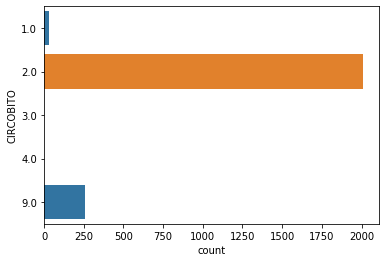

In [74]:
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(df_causabas, y="CIRCOBITO", palette=c_palette)

Filtering CAUSABAS != NULL, CAUSABAS = X60-X84, CIRCOBITO = 2 or 9 (no Accidental suicides).

In [161]:
df2 = df_causabas[((df_causabas.CIRCOBITO==2.0) == True) | ((df_causabas.CIRCOBITO==9.0) == True)]

(2265, 6)

Now that we filtered the useful data for suicide, let's analyse the quantity of each classification in LINHAII, which are the pre-existing conditions of the patient before commiting suicide.

Creating CID array:

In [76]:
cid = []
for index, row in df2.iterrows():
    if str(row["LINHAII"]) != "nan":
        causa2 = str(row["LINHAII"])
        x = causa2.split("*")
        x.pop(0)
        for causa in x:
            if re.match('A|B', causa):
                cid.append("A00-B99: Algumas doenças infecciosas e parasitárias")
            if re.match('C|D[0-3]|D4[0-8]', causa):
                cid.append("C00-D48: Neoplasmas (tumores)")
            if re.match('D[5-9]', causa):
                cid.append("D50-D89: Doenças do sangue e dos órgãos hematopoéticos e alguns transtornos imunitários")
            if re.match('E', causa):
                cid.append("E00-E90: Doenças endócrinas, nutricionais e metabólicas")
            if re.match('F', causa):
                cid.append("F00-F99: Transtornos mentais e comportamentais")
            if re.match('G', causa):
                cid.append("G00-G99: Doenças do sistema nervoso")
            if re.match('H[0-5]', causa):
                cid.append("H00-H59: Doenças do olho e anexos")
            if re.match('H[6-9]', causa):
                cid.append("H60-H95: Doenças do ouvido e da apófise mastoide")
            if re.match('I', causa):
                cid.append("I00-I99: Doenças do aparelho circulatório")
            if re.match('J', causa):
                cid.append("J00-J99: Doenças do aparelho respiratório")
            if re.match('K', causa):
                cid.append("K00-K93: Doenças do aparelho digestivo")
            if re.match('L', causa):
                cid.append("L00-L99: Doenças da pele e do tecido subcutâneo")
            if re.match('M', causa):
                cid.append("M00-M99: Doenças do sistema osteomuscular e do tecido conjuntivo")
            if re.match('N', causa):
                cid.append("N00-N99: Doenças do aparelho geniturinário")
            if re.match('O', causa):
                cid.append("O00-O99: Gravidez, parto e puerpério")
            if re.match('P', causa):
                cid.append("P00-P96: Algumas afecções originadas no período perinatal")
            if re.match('Q', causa):
                cid.append("Q00-Q99: Malformações congênitas, deformidades e anomalias cromossômicas")
            if re.match('R', causa):
                cid.append("R00-R99: Sintomas, sinais e achados anormais de exames clínicos e de laboratório, não classificados em outra parte")
            if re.match('S|T', causa):
                cid.append("S00-T98: Lesões, envenenamentos e algumas outras consequências de causas externas")
            if re.match('[V-Y]', causa):
                cid.append("V01-Y98: Causas externas de morbidade e de mortalidade")
            if re.match('Z', causa):
                cid.append("Z00-Z99: Fatores que influenciam o estado de saúde e o contato com os serviços de saúde")
            if re.match('U', causa):
                cid.append("U00-U99: Códigos para propósitos especiais")

Plotting result

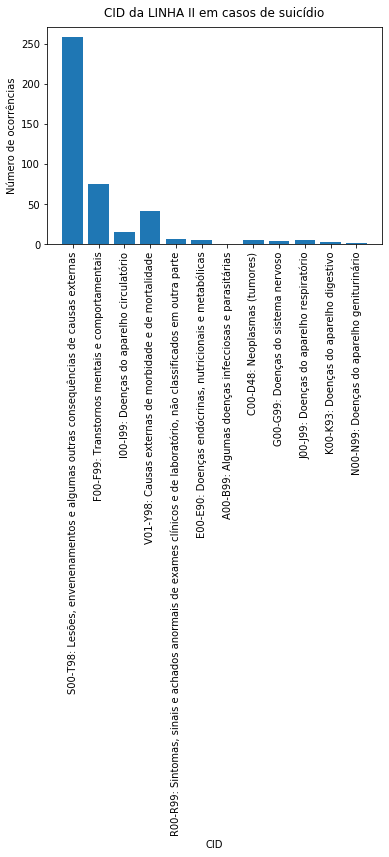

In [82]:
w = Counter(cid)
plt.xticks(rotation='vertical')
plt.bar(w.keys(), w.values())
plt.title("CID da LINHA II em casos de suicídio", loc="center", pad=10.0)
plt.ylabel("Número de ocorrências")
plt.xlabel("CID")
plt.savefig('suicide_occurences_by_linhaii_cid.png', bbox_inches = 'tight')

* ## CID distributions among São Paulo's cities

Now, let's evaluate the distribution of this categories for each city in the state of São Paulo:

In [106]:
df_municipalities = pd.read_csv('CADMUN.csv')

In [107]:
df_municipalities.head()

,MUNCOD,MUNCODDV,SITUACAO,MUNSINP,MUNSIAFI,MUNNOME,MUNNOMEX,OBSERV,MUNSINON,MUNSINONDV,...,CSAUDCOD,RMETRCOD,AGLCOD,ANOINST,ANOEXT,SUCESSOR,LATITUDE,LONGITUDE,ALTITUDE,AREA
0,0,0,IGNOR,0.0,NaN,Ignorado ou exterior,IGNORADO OU EXTERIOR,Ignorado,", ,000001-009999",", ,0000001-0099999",...,0,0,0,NaN,NaN,NaN,0.000,0.000,0.0,0.000
1,110000,1100000,IGNOR,26000.0,NaN,Município ignorado - RO,MUNICIPIO IGNORADO - RO,NaN,",119999",",1199999",...,11000,1100,1100,NaN,NaN,NaN,0.000,0.000,0.0,0.000
2,110001,1100015,ATIVO,26016.0,33.0,Alta Floresta D'Oeste,ALTA FLORESTA D'OESTE,NaN,NaN,NaN,...,11900,1190,1190,1986.0,NaN,NaN,-11.929,-61.996,350.0,7066.702
3,110002,1100023,ATIVO,26004.0,7.0,Ariquemes,ARIQUEMES,NaN,NaN,NaN,...,11900,1190,1190,1977.0,NaN,NaN,-9.913,-63.041,142.0,4426.558
4,110003,1100031,ATIVO,26020.0,37.0,Cabixi,CABIXI,NaN,NaN,NaN,...,11900,1190,1190,1989.0,NaN,NaN,-13.492,-60.545,230.0,1314.355


In [180]:
df_municipalities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 3285 to 3930
Data columns (total 3 columns):
MUNCOD     646 non-null int64
MUNNOME    646 non-null object
CAPITAL    646 non-null object
dtypes: int64(1), object(2)
memory usage: 20.2+ KB


We filter the cities in the state of São Paulo (UFCODE=35).

In [120]:
df_municipalities = df_municipalities[["MUNCOD", "MUNNOME", "CAPITAL", "UFCOD"]]
df_municipalities = df_municipalities.loc[df_municipalities["UFCOD"]==35]
df_municipalities = df_municipalities.drop(columns=["UFCOD"])
df_municipalities.head()

,MUNCOD,MUNNOME,CAPITAL
3285,350000,Município ignorado - SP,N
3286,350010,Adamantina,N
3287,350020,Adolfo,N
3288,350030,Aguaí,N
3289,350040,Águas da Prata,N


We'd like to reduce the _df2_, so that it relates each São Paulo's city to its most significant CID code in LINHAII. But the problem is that we have cities that have **many NaN values for LINHAII**.

Example for Campinas (350945):

* Without NaNs

In [176]:
df2_city = df2[["CODMUNOCOR", "LINHAII"]]
df2_city = df2_city.loc[(df2_city["CODMUNOCOR"]==350950) & (df2_city["LINHAII"].astype(str)!="nan")]
df2_city.shape

(3, 2)

* With NaNs

In [177]:
df2_city = df2[["CODMUNOCOR", "LINHAII"]]
df2_city = df2_city.loc[(df2_city["CODMUNOCOR"]==350950)]
df2_city.shape

(67, 2)

That's because, in fact, we have few lines with some value for LINHAII among the ones that represent suicide (a difference of 314 lines):

* Only NaNs

In [172]:
df2_city = df2[["CODMUNOCOR", "LINHAII"]]
df2_city = df2_city.loc[(df2_city["LINHAII"].astype(str)=="nan")]
df2_city.shape

(1951, 2)

* All lines

In [173]:
df2_city = df2[["CODMUNOCOR", "LINHAII"]]
df2_city.shape

(2265, 2)

This can be seen also in the plotting result for CID number of occurencies. The total of occurences sums up to approximately 400 registered classifications.

That's why we change our analysis of distribution to use the CAUSABAS because it **has no NULL values**.